# 切换工作目录到主目录

In [1]:
import os
os.chdir('../')
os.listdir()

['out-test2.mp4',
 '.ipynb_checkpoints',
 'data',
 'requirements.txt',
 'configs',
 '.circleci',
 'setup.py',
 '.readthedocs.yml',
 '.codespellrc',
 'outputs',
 'docker',
 'LICENSE',
 '.github',
 'CITATION.cff',
 '.git',
 '.pre-commit-config.yaml',
 'wildreceipt.tar',
 'MANIFEST.in',
 'README_zh-CN.md',
 '.coveragerc',
 'dict_printed_chinese_english_digits.txt',
 'mmocr.egg-info',
 'demo',
 '.pylintrc',
 'requirements',
 'tests',
 'mmocr',
 'tutorials',
 'tools',
 'docs',
 'README.md',
 'font.TTF',
 'model-index.yml',
 'setup.cfg',
 'resources',
 '.gitignore']

# 导入工具包

In [3]:
# 导入pytorch
import torch, torchvision

# 导入mmcv和mmdet
import mmcv
import mmdet

# 导入mmocr
# import mmocr

# from mmcv.ops import get_compiling_cuda_version, get_compiler_version

In [2]:
# 导入opencv-python
import cv2

# 导入可视化工具包matplotlib，并让绘制的图像嵌入在notebook中
import matplotlib.pyplot as plt
%matplotlib inline

# 定义可视化图像函数
def look_img_path(img_path):
    '''opencv读入图像，matplotlib可视化格式为RGB，因此需将BGR转RGB，最后可视化出来'''
    img = cv2.imread(img_path)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
# 定义可视化图像函数
def look_img(img):
    '''输入array，matplotlib可视化格式为RGB，因此需将BGR转RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

在大数据集上训练很耗时，需要好几个小时，所以我们用迷你数据集训练一个基于SAR的文本识别器。

基本步骤：

1.将数据集整理为MMOCR支持的格式，例如用于文本检测的COCO格式。

标注文件可以是.txt文件，也可以是.lmdb格式，取决于数据集大小。我们提供的迷你数据集已做好了整理。

2.指定训练配置

3.训练模型

玩具数据集包含10张图像和对应的文本txt、lmdb格式，
[toy_dataset](https://github.com/open-mmlab/mmocr/tree/main/tests/data/toy_dataset). 

# 探索toy dataset

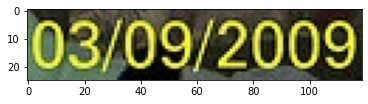

In [6]:
look_img_path('tests/data/ocr_toy_dataset/imgs/1036169.jpg')

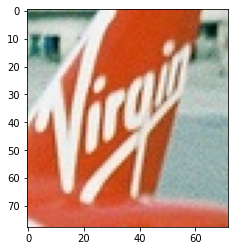

In [9]:
look_img_path('tests/data/ocr_toy_dataset/imgs/1058891.jpg')

In [7]:
# 查看标注文件
!cat tests/data/ocr_toy_dataset/label.txt

1223731.jpg GRAND
1223733.jpg HOTEL
1223732.jpg HOTEL
1223729.jpg PACIFIC
1036169.jpg 03/09/2009
1190237.jpg ANING
1058891.jpg Virgin
1058892.jpg america
1240078.jpg ATTACK
1210236.jpg DAVIDSON


# 修改训练配置文件

In [10]:
from mmcv import Config
cfg = Config.fromfile('./configs/textrecog/sar/sar_r31_parallel_decoder_toy_dataset.py')

In [11]:
from mmdet.apis import set_random_seed

# Set up working dir to save files and logs.
cfg.work_dir = './demo/tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.001 / 8
cfg.lr_config.warmup = None
# Choose to log training results every 40 images to reduce the size of log file. 
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint_config = dict(interval=1)
log_config = dict(interval=40, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = None
workflow = [('train', 1)]
label_convertor = dict(
    type='AttnConvertor', dict_type='DICT90', with_unknown=True)
model = dict(
    type='SARNet',
    backbone=dict(type='ResNet31OCR'),
    encoder=dict(
        type='SAREncoder', enc_bi_rnn=False, enc_do_rnn=0.1, enc_gru=False),
    decoder=dict(
        type='ParallelSARDecoder',
        enc_bi_rnn=False,
        dec_bi_rnn=False,
        dec_do_rnn=0,
        dec_gru=False,
        pred_dropout=0.1,
        d_k=512,
        pred_concat=True),
    loss=dict(type='SARLoss'),
    label_convertor=dict(
        type='AttnConvertor', dict_type='DICT90', with_unknown=True),
    max_seq_len=30)
optimizer = dict(type='Adam', lr=0.000125)
optimizer_config = dict(grad_clip=None)
lr_config = dict(policy='step', step=[3, 4], warmup=None)
total_e

# 在toy dataset上训练基于SAR的文本识别器

In [12]:
from mmocr.datasets import build_dataset
from mmocr.models import build_detector
from mmocr.apis import train_detector
import os.path as osp

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/featurize/mmocr/mmocr/apis/train.py:82: UserWarning: config is now expected to have a `runner` section, please set `runner` in your config.
  'please set `runner` in your config.', UserWarning)
/home/featurize/mmocr/mmocr/apis/utils.py:53: UserWarning: Remove "MultiRotateAugOCR" to support batch inference since samples_per_gpu > 1.
  warnings.warn(warning_msg)
2021-12-24 17:48:23,963 - mmocr - INFO - Start running, host: featurize@featurize, work_dir: /home/featurize/mmocr/demo/tutorial_exps
2021-12-24 17:48:23,964 - mmocr - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(NORMAL      ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) EvalHook                           
(LOW         ) IterTimerHook                    

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 33.3 task/s, elapsed: 0s, ETA:     0s

2021-12-24 17:48:47,594 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2021-12-24 17:48:47,604 - mmocr - INFO - Epoch(val) [1][2]	0_word_acc: 0.8000, 0_word_acc_ignore_case: 0.8000, 0_word_acc_ignore_case_symbol: 0.8000, 0_char_recall: 0.8065, 0_char_precision: 0.8333, 0_1-N.E.D: 0.8000
2021-12-24 17:48:52,738 - mmocr - INFO - Epoch [2][40/250]	lr: 1.250e-04, eta: 0:01:23, time: 0.128, data_time: 0.054, memory: 1783, loss_ce: 0.4561, loss: 0.4561
2021-12-24 17:48:55,756 - mmocr - INFO - Epoch [2][80/250]	lr: 1.250e-04, eta: 0:01:19, time: 0.075, data_time: 0.002, memory: 1783, loss_ce: 0.3424, loss: 0.3424
2021-12-24 17:48:58,704 - mmocr - INFO - Epoch [2][120/250]	lr: 1.250e-04, eta: 0:01:14, time: 0.074, data_time: 0.002, memory: 1783, loss_ce: 0.3988, loss: 0.3988
2021-12-24 17:49:01,678 - mmocr - INFO - Epoch [2][160/250]	lr: 1.250e-04, eta: 0:01:10, time: 0.074, data_time: 0.002, memory: 1783, loss_ce: 0.3898, loss: 0.3898
2021-12-24 17:49:0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 32.8 task/s, elapsed: 0s, ETA:     0s

2021-12-24 17:49:11,106 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2021-12-24 17:49:11,108 - mmocr - INFO - Epoch(val) [2][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000
2021-12-24 17:49:16,201 - mmocr - INFO - Epoch [3][40/250]	lr: 1.250e-04, eta: 0:00:59, time: 0.127, data_time: 0.053, memory: 1783, loss_ce: 0.2781, loss: 0.2781
2021-12-24 17:49:19,164 - mmocr - INFO - Epoch [3][80/250]	lr: 1.250e-04, eta: 0:00:55, time: 0.074, data_time: 0.002, memory: 1783, loss_ce: 0.2898, loss: 0.2898
2021-12-24 17:49:22,140 - mmocr - INFO - Epoch [3][120/250]	lr: 1.250e-04, eta: 0:00:52, time: 0.074, data_time: 0.001, memory: 1783, loss_ce: 0.2677, loss: 0.2677
2021-12-24 17:49:25,124 - mmocr - INFO - Epoch [3][160/250]	lr: 1.250e-04, eta: 0:00:48, time: 0.075, data_time: 0.002, memory: 1783, loss_ce: 0.2708, loss: 0.2708
2021-12-24 17:49:2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 35.2 task/s, elapsed: 0s, ETA:     0s

2021-12-24 17:49:34,100 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2021-12-24 17:49:34,103 - mmocr - INFO - Epoch(val) [3][2]	0_word_acc: 0.5000, 0_word_acc_ignore_case: 0.5000, 0_word_acc_ignore_case_symbol: 0.5000, 0_char_recall: 0.5323, 0_char_precision: 0.5789, 0_1-N.E.D: 0.5343
2021-12-24 17:49:39,193 - mmocr - INFO - Epoch [4][40/250]	lr: 1.250e-05, eta: 0:00:38, time: 0.127, data_time: 0.054, memory: 1783, loss_ce: 0.3561, loss: 0.3561
2021-12-24 17:49:42,164 - mmocr - INFO - Epoch [4][80/250]	lr: 1.250e-05, eta: 0:00:34, time: 0.074, data_time: 0.002, memory: 1783, loss_ce: 0.2985, loss: 0.2985
2021-12-24 17:49:45,186 - mmocr - INFO - Epoch [4][120/250]	lr: 1.250e-05, eta: 0:00:31, time: 0.076, data_time: 0.002, memory: 1783, loss_ce: 0.2982, loss: 0.2982
2021-12-24 17:49:48,206 - mmocr - INFO - Epoch [4][160/250]	lr: 1.250e-05, eta: 0:00:27, time: 0.075, data_time: 0.002, memory: 1783, loss_ce: 0.3136, loss: 0.3136
2021-12-24 17:49:5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 32.5 task/s, elapsed: 0s, ETA:     0s

2021-12-24 17:49:57,628 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2021-12-24 17:49:57,630 - mmocr - INFO - Epoch(val) [4][2]	0_word_acc: 0.8000, 0_word_acc_ignore_case: 0.8000, 0_word_acc_ignore_case_symbol: 0.8000, 0_char_recall: 0.8065, 0_char_precision: 0.8333, 0_1-N.E.D: 0.8000
2021-12-24 17:50:02,762 - mmocr - INFO - Epoch [5][40/250]	lr: 1.250e-06, eta: 0:00:17, time: 0.128, data_time: 0.054, memory: 1783, loss_ce: 0.3003, loss: 0.3003
2021-12-24 17:50:05,791 - mmocr - INFO - Epoch [5][80/250]	lr: 1.250e-06, eta: 0:00:13, time: 0.076, data_time: 0.002, memory: 1783, loss_ce: 0.2694, loss: 0.2694
2021-12-24 17:50:08,838 - mmocr - INFO - Epoch [5][120/250]	lr: 1.250e-06, eta: 0:00:10, time: 0.076, data_time: 0.002, memory: 1783, loss_ce: 0.2851, loss: 0.2851
2021-12-24 17:50:11,860 - mmocr - INFO - Epoch [5][160/250]	lr: 1.250e-06, eta: 0:00:07, time: 0.076, data_time: 0.001, memory: 1783, loss_ce: 0.2738, loss: 0.2738
2021-12-24 17:50:1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 36.2 task/s, elapsed: 0s, ETA:     0s

2021-12-24 17:50:21,075 - mmocr - INFO - 
Evaluateing tests/data/ocr_toy_dataset/label.lmdb with 10 images now
2021-12-24 17:50:21,082 - mmocr - INFO - Epoch(val) [5][2]	0_word_acc: 1.0000, 0_word_acc_ignore_case: 1.0000, 0_word_acc_ignore_case_symbol: 1.0000, 0_char_recall: 1.0000, 0_char_precision: 1.0000, 0_1-N.E.D: 1.0000


# 测试训练出的模型性能，可视化预测结果

使用最新的模型checkpoint，用hmean-iou指标，预测结果存储在`./outputs`

In [16]:
from mmocr.apis import init_detector, model_inference

In [34]:
img = './tests/data/ocr_toy_dataset/imgs/1036169.jpg' # 指定待预测图像路径
checkpoint = "./demo/tutorial_exps/epoch_5.pth" # 指定模型checkpoint文件
out_file = 'outputs/demo-out.jpg'

model = init_detector(cfg, checkpoint, device="cuda:0")
if model.cfg.data.test['type'] == 'ConcatDataset':
    model.cfg.data.test.pipeline = model.cfg.data.test['datasets'][0].pipeline

result = model_inference(model, img)
print(f'result: {result}')

img = model.show_result(img, result, out_file=out_file, show=False)

mmcv.imwrite(img, out_file)

load checkpoint from local path: ./demo/tutorial_exps/epoch_5.pth
result: {'text': '03/09/2009', 'score': 0.9982177376747131}


True

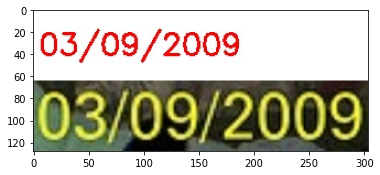

In [35]:
look_img_path('outputs/demo-out.jpg')